## **Step 01: Install easyfsl**
### EasyFSL typically refers to "Easy Few-Shot Learning," which is a framework or toolkit designed for few-shot learning (FSL)

In [13]:
!pip install easyfsl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.8/72.8 kB 4.1 MB/s eta 0:00:00


## **Step 02: Import necessary libraries**

In [14]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import Omniglot
from torchvision.models import resnet18
from tqdm import tqdm

from easyfsl.samplers import TaskSampler
from easyfsl.utils import plot_images, sliding_average

## **Step 03: Loading and Transforming the Omniglot Dataset**
### In this section, we prepare the Omniglot dataset for training and testing by applying a series of transformations to the images.

In [15]:
image_size = 28


train_set = Omniglot(
    root="./data",
    background=True,
    transform=transforms.Compose(
        [
            transforms.Grayscale(num_output_channels=3),
            transforms.RandomResizedCrop(image_size),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
        ]
    ),
    download=True,
)
test_set = Omniglot(
    root="./data",
    background=False,
    transform=transforms.Compose(
        [
            transforms.Grayscale(num_output_channels=3),
            transforms.Resize([int(image_size * 1.15), int(image_size * 1.15)]),
            transforms.CenterCrop(image_size),
            transforms.ToTensor(),
        ]
    ),
    download=True,
)

100%|██████████| 9464212/9464212 [00:00<00:00, 100763503.61it/s]

Extracting ./data/omniglot-py/images_background.zip to ./data/omniglot-py


100%|██████████| 6462886/6462886 [00:00<00:00, 158282534.65it/s]

Extracting ./data/omniglot-py/images_evaluation.zip to ./data/omniglot-py


## **Step 04: Implementing Matching Networks**


In [16]:
# matching networks :

import torch
import torch.nn as nn
import torch.nn.functional as F

# Simple CNN for embedding network
class SimpleCNN(nn.Module):
    def __init__(self, embedding_dim=64):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.fc1 = None  # This will be initialized later dynamically
        self.embedding_dim = embedding_dim

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))  # First convolution and pooling
        x = F.relu(F.max_pool2d(self.conv2(x), 2))  # Second convolution and pooling
        x = x.view(x.size(0), -1)  # Flatten the tensor

        # Dynamically define the fully connected layer based on the input size
        if self.fc1 is None:
            self.fc1 = nn.Linear(x.size(1), self.embedding_dim)

        x = self.fc1(x)  # Fully connected layer for embedding
        return x

class MatchingNetwork(nn.Module):
    def __init__(self, embedding_net, n_classes, n_support):
        super(MatchingNetwork, self).__init__()
        self.embedding_net = embedding_net
        self.n_classes = n_classes
        self.n_support = n_support

    def forward(self, support_images, support_labels, query_images):
        # Get embeddings for support and query images
        support_embeddings = self.embedding_net(support_images)  # Shape: (n_support, embedding_dim)
        query_embeddings = self.embedding_net(query_images)      # Shape: (n_query, embedding_dim)

        # Compute cosine similarity
        similarities = F.cosine_similarity(query_embeddings.unsqueeze(1),
                                           support_embeddings.unsqueeze(0), dim=2)  # Shape: (n_query, n_support)

        # Softmax over support samples to get the probability distribution over classes
        weights = F.softmax(similarities, dim=1)  # Shape: (n_query, n_support)

        # Convert support labels to one-hot encoding
        support_one_hot = F.one_hot(support_labels, self.n_classes).float()  # Shape: (n_support, n_classes)

        # Predict the class of the query images
        query_predictions = torch.matmul(weights, support_one_hot)  # Shape: (n_query, n_classes)

        return query_predictions

# Instantiate the model
embedding_net = SimpleCNN(embedding_dim=64)
model = MatchingNetwork(embedding_net=embedding_net, n_classes=5, n_support=5)

# Example usage
support_images = torch.rand(5, 1, 28, 28)  # 5 support images, 1 channel (grayscale), 28x28 size
query_images = torch.rand(3, 1, 28, 28)    # 3 query images
support_labels = torch.tensor([0, 1, 2, 3, 4])  # Labels for the support images

# Forward pass
query_predictions = model(support_images, support_labels, query_images)
print(query_predictions)


tensor([[0.2004, 0.2002, 0.1997, 0.2000, 0.1997],
        [0.2008, 0.1996, 0.1992, 0.1993, 0.2011],
        [0.2003, 0.2000, 0.2000, 0.1987, 0.2009]], grad_fn=<MmBackward0>)


## **Step 05: Setting Up Evaluation Tasks for Few-Shot Learning**
### In this section, we define and prepare the evaluation tasks for few-shot learning. We use a task sampler to create tasks with a specified number of classes, support images, and query images.

In [17]:
N_WAY = 5 # Number of classes in a task
N_SHOT = 5 # Number of images per class in the support set
N_QUERY = 10 # Number of images per class in the query set
N_EVALUATION_TASKS = 100

# The sampler needs a dataset with a "get_labels" method. Check the code if you have any doubt!
test_set.get_labels = lambda: [instance[1] for instance in test_set._flat_character_images]
test_sampler = TaskSampler(
    test_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS
)

test_loader = DataLoader(
    test_set,
    batch_sampler=test_sampler,
    num_workers=12,
    pin_memory=True,
    collate_fn=test_sampler.episodic_collate_fn,
)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## **Step 06: Visualizing Support and Query Images**
### In this section, we visualize examples of support and query images from one of the evaluation tasks. This helps us understand the data that the model will process during the few-shot learning tasks.

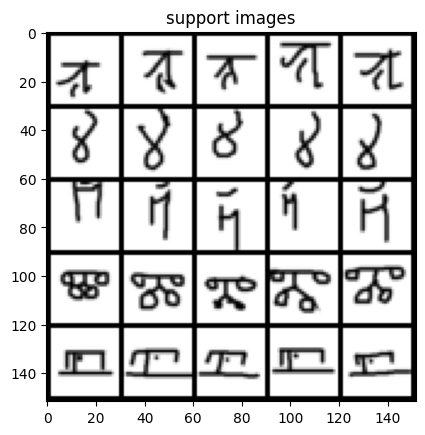

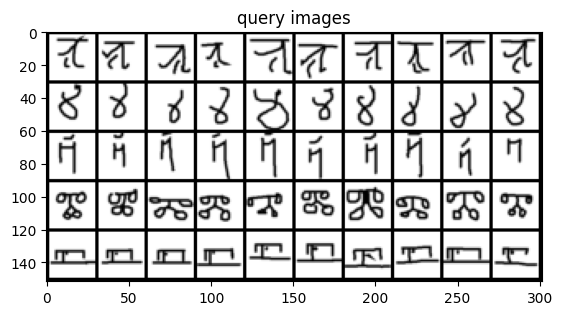

In [18]:
(
    example_support_images,
    example_support_labels,
    example_query_images,
    example_query_labels,
    example_class_ids,
) = next(iter(test_loader))

plot_images(example_support_images, "support images", images_per_row=N_SHOT)
plot_images(example_query_images, "query images", images_per_row=N_QUERY)

## **Step 07: Evaluating the Model on an Example Task**
### In this section, we evaluate the Prototypical Networks model on an example task from the evaluation set. We compute the predicted labels for the query images and compare them with the ground truth labels.

In [19]:
# Move the model to GPU
model = model.cuda()

# Convert RGB images (3 channels) to grayscale (1 channel)
example_support_images_gray = torch.mean(example_support_images, dim=1, keepdim=True).cuda()
example_query_images_gray = torch.mean(example_query_images, dim=1, keepdim=True).cuda()

# Evaluate model
model.eval()
example_scores = model(
    example_support_images_gray,
    example_support_labels.cuda(),
    example_query_images_gray,
).detach()

_, example_predicted_labels = torch.max(example_scores.data, 1)

print("Ground Truth / Predicted")
for i in range(len(example_query_labels)):
    print(
        f"{test_set._characters[example_class_ids[example_query_labels[i]]]} / {test_set._characters[example_class_ids[example_predicted_labels[i]]]}"
    )


Ground Truth / Predicted
Sylheti/character25 / Syriac_(Serto)/character09
Sylheti/character25 / Sylheti/character25
Sylheti/character25 / Sylheti/character25
Sylheti/character25 / Sylheti/character25
Sylheti/character25 / Keble/character16
Sylheti/character25 / Sylheti/character25
Sylheti/character25 / Sylheti/character25
Sylheti/character25 / Sylheti/character25
Sylheti/character25 / Sylheti/character25
Sylheti/character25 / Sylheti/character25
Syriac_(Serto)/character09 / Syriac_(Serto)/character09
Syriac_(Serto)/character09 / Syriac_(Serto)/character09
Syriac_(Serto)/character09 / Sylheti/character25
Syriac_(Serto)/character09 / Sylheti/character25
Syriac_(Serto)/character09 / Keble/character16
Syriac_(Serto)/character09 / Atemayar_Qelisayer/character22
Syriac_(Serto)/character09 / Syriac_(Serto)/character09
Syriac_(Serto)/character09 / Syriac_(Serto)/character09
Syriac_(Serto)/character09 / Keble/character16
Syriac_(Serto)/character09 / Syriac_(Serto)/character09
Atemayar_Qelisayer

## **Step 08:  Evaluating the Model on Multiple Tasks**
### In this section, we define and use functions to evaluate the Prototypical Networks model on multiple tasks. This involves computing the model's accuracy over the entire test set.

In [20]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm

# Function to evaluate on one task
def evaluate_on_one_task(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> [int, int]:

    # Convert RGB images to grayscale (1 channel)
    support_images_gray = torch.mean(support_images, dim=1, keepdim=True).cuda()
    query_images_gray = torch.mean(query_images, dim=1, keepdim=True).cuda()

    # Model forward pass
    return (
        torch.max(
            model(support_images_gray, support_labels.cuda(), query_images_gray)
            .detach()
            .data,
            1,
        )[1]
        == query_labels.cuda()
    ).sum().item(), len(query_labels)


# Evaluation function
def evaluate(data_loader: DataLoader):
    total_predictions = 0
    correct_predictions = 0

    # Set the model to evaluation mode
    model.eval()
    with torch.no_grad():
        for episode_index, (
            support_images,
            support_labels,
            query_images,
            query_labels,
            class_ids,
        ) in tqdm(enumerate(data_loader), total=len(data_loader)):

            correct, total = evaluate_on_one_task(
                support_images, support_labels, query_images, query_labels
            )

            total_predictions += total
            correct_predictions += correct

    # Print final accuracy
    print(
        f"Model tested on {len(data_loader)} tasks. Accuracy: {(100 * correct_predictions / total_predictions):.2f}%"
    )


# Call the evaluation function with the test loader
evaluate(test_loader)


100%|██████████| 100/100 [00:04<00:00, 23.25it/s]

Model tested on 100 tasks. Accuracy: 56.68%


## **Step 09: Setting Up Training Data and Sampler for Episodic Training**
### In this section, we prepare the training data and define a sampler to create few-shot learning tasks for training the Prototypical Networks model.

In [21]:
N_TRAINING_EPISODES = 3000
N_VALIDATION_TASKS = 100

# train_set.labels = [instance[1] for instance in train_set._flat_character_images]   #incorrect, ignore this line; the following line is correct.
train_set.get_labels = lambda: [instance[1] for instance in train_set._flat_character_images]

train_sampler = TaskSampler(
    train_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_TRAINING_EPISODES
)
train_loader = DataLoader(
    train_set,
    batch_sampler=train_sampler,
    num_workers=12,
    pin_memory=True,
    collate_fn=train_sampler.episodic_collate_fn,
)

## **Step 10: Setting Up Loss Function and Optimizer**
### Defining the Loss Function (Cross Entropy Loss) and Optimizer (Adam)

In [22]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


def fit(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> float:
    optimizer.zero_grad()
    classification_scores = model(
        support_images.cuda(), support_labels.cuda(), query_images.cuda()
    )

    loss = criterion(classification_scores, query_labels.cuda())
    loss.backward()
    optimizer.step()

    return loss.item()

## **Step 11: Training Loop with Logging**

In [24]:
import torch
from tqdm import tqdm

log_update_frequency = 10

# Function to compute sliding average (assuming it is already defined)
def sliding_average(values, window_size):
    if len(values) < window_size:
        return sum(values) / len(values)
    else:
        return sum(values[-window_size:]) / window_size

# Training loop
all_loss = []
model.train()
with tqdm(enumerate(train_loader), total=len(train_loader)) as tqdm_train:
    for episode_index, (
        support_images,
        support_labels,
        query_images,
        query_labels,
        _,
    ) in tqdm_train:

        # Convert support and query images to grayscale (1 channel)
        support_images_gray = torch.mean(support_images, dim=1, keepdim=True).cuda()
        query_images_gray = torch.mean(query_images, dim=1, keepdim=True).cuda()

        # Call the fit function with grayscale images
        loss_value = fit(support_images_gray, support_labels.cuda(), query_images_gray, query_labels.cuda())
        all_loss.append(loss_value)

        # Logging the sliding average of loss
        if episode_index % log_update_frequency == 0:
            tqdm_train.set_postfix(loss=sliding_average(all_loss, log_update_frequency))


100%|██████████| 3000/3000 [02:54<00:00, 17.21it/s, loss=1.53]


 ## **Step 12: Evaluate the performance of the Prototypical Networks model on the test dataset**

In [27]:

evaluate(test_loader)

100%|██████████| 100/100 [00:07<00:00, 13.59it/s]

Model tested on 100 tasks. Accuracy: 75.24%


In [26]:
!pip install fvcore
from fvcore.nn import FlopCountAnalysis

In [28]:
import torch
import torch.nn as nn
import time
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# 1. Define the Model with dynamic input size calculation
class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()

        # Initialize the Linear layer with placeholder for input features
        self.fc = None

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.flatten(x)

        # Dynamically initialize the Linear layer the first time we run forward pass
        if self.fc is None:
            num_features = x.size(1)  # Calculate the input size dynamically
            self.fc = nn.Linear(num_features, 10).cuda()  # 10 output classes, replace as necessary

        x = self.fc(x)
        return x

model = SimpleModel().cuda()

# 2. Prepare Dataset and DataLoader
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
])

# Use your actual dataset instead of FakeData
test_dataset = datasets.FakeData(transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 3. Inference Time Calculation
start_time = time.time()
model.eval()

with torch.no_grad():
    for batch in test_loader:
        support_images = batch[0]
        support_images_gray = torch.mean(support_images, dim=1, keepdim=True).cuda()

        # Perform the inference
        _ = model(support_images_gray)

end_time = time.time()
inference_time = end_time - start_time
print(f'Inference time for one batch: {inference_time:.4f} seconds')

# 4. Model Size Calculation
torch.save(model.state_dict(), 'model_temp.pth')
import os
model_size = os.path.getsize('model_temp.pth') / (1024 * 1024)  # Convert bytes to MB
print(f'Model size: {model_size:.2f} MB')
os.remove('model_temp.pth')

# 5. FLOPs Calculation
from fvcore.nn import FlopCountAnalysis
support_images_gray = next(iter(test_loader))[0]
support_images_gray = torch.mean(support_images_gray, dim=1, keepdim=True).cuda()

flops = FlopCountAnalysis(model, support_images_gray)
print(f"FLOPs: {flops.total() / 1e9:.2f} GFLOPs")


Inference time for one batch: 3.6265 seconds
Model size: 60.16 MB
FLOPs: 0.96 GFLOPs
